# 第3章 k近邻法

In [1]:
import math
from itertools import combinations

引入范数的概念，计算两向量间的距离：  
$L_p (x_i,x_j)=[\sum_{l=1}^n| x_i^{(l)} - x_j^{(l)}|^p]^{1/p}$  

- p = 1 曼哈顿距离
- p = 2 欧氏距离
- p = inf  闵式距离minkowski_distance 

In [2]:
#计算x与y两样本间的距离
def L(x,y,p):
    if len(x)==len(y) and len(x)>1:
        sum=0
        for i in range(len(x)):
            sum+=math.pow(abs(x[i]- y[i]),p)
        return math.pow(sum,1/p)
    else:
        return 0

In [3]:
#计算结果
L((1,1),(4,4),1)

6.0

In [4]:
#P39例3.1 计算距离x1的最近点
x1=(1,1)
x2=(5,1)
x3=(4,4)

In [5]:
for i in range(1,5):
    dist={'{}阶范数{}to (1,1)'.format(i,x):L(x1,x,i) for x in [x2,x3]}
    print(min(zip(dist.values(),dist.keys())))

(4.0, '1阶范数(5, 1)to (1,1)')
(4.0, '2阶范数(5, 1)to (1,1)')
(3.7797631496846193, '3阶范数(4, 4)to (1,1)')
(3.5676213450081633, '4阶范数(4, 4)to (1,1)')


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter

In [7]:
#导入数据集
iris=load_iris()
df=pd.DataFrame(iris.data,columns=iris.feature_names)
df['label']=iris.target
df.columns=['sepal length','sepal width','petal length','petal width','label']

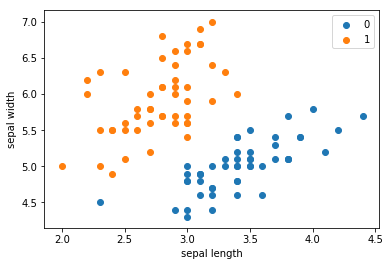

In [8]:
plt.scatter(df['sepal width'][:50],df['sepal length'][:50],label='0')
plt.scatter(df['sepal width'][50:100],df['sepal length'][50:100],label='1')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [9]:
#以萼片的长宽为特征，划分测试集和训练集
data=np.array(df.iloc[:100,[0,1,-1]])
X,y=data[:,:-1],data[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [10]:
class KNN:
    def __init__(self, X_train, y_train, n_neighbors=3, p=2):
        '''
        parameter:n_neighbours 临近点个数
        parameter：p 距离范数
        '''
        self.n = n_neighbors
        self.p = p
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self,X):
        #构建点与距离的列表
        knn_list=[]
        #先生成一个长度为3的关于点和距离的列表
        for i in range(self.n):
            dist=np.linalg.norm(X - self.X_train[i],ord=self.p)
            knn_list.append((dist,self.y_train[i]))
        
        #选择距离最近的三个点
        for j in range(self.n,len(self.X_train)):
            max_index = knn_list.index(max(knn_list,key=lambda x:x[0]))  #找到knn_list中第一个元素最大的那个值的索引
            num = np.linalg.norm(X-self.X_train[j],ord=self.p)       
            if knn_list[max_index][0] > num:                         #如果当前knn_list中的最大距离大于计算得到的dist，则dist替换knn_list
                knn_list[max_index]=(num , self.y_train[j])
        
        #将剩下的数据进行排序，并选出类别最多的一组
        knn=[k[-1] for k in knn_list]
        count_pairs = Counter(knn)
        max_count=sorted(count_pairs,key=lambda x:x)[-1]
        return max_count
               
    def score(self,X_test,y_test):
        count=0
        for X,y in zip(X_test,y_test):
            label = self.predict(X)
            if label == y:
                count += 1
        return count/len(X_test)

In [11]:
clf = KNN(X_train,y_train)

In [12]:
clf.score(X_test,y_test)

1.0

# scikit-learn

- n_neighbors:临近点的个数  
- p：距离度量
- algorithm：近邻算法，可选{'auto','ball_tree','kd_tree','brute'}
- weights:确定近邻的权重

In [13]:
# 调用sklearn的KNN模块
from sklearn.neighbors import KNeighborsClassifier

In [14]:
clf_sk = KNeighborsClassifier()
clf_sk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [15]:
clf_sk.score(X_test,y_test)

1.0

### kd树

In [16]:
# 生成kd-tree
class KdNode(object):
    def __init__(self, dom_elt, split, left, right):
        self.dom_elt = dom_elt
        self.split   = split
        self.left    = left
        self.right   = right

class Kdtree(object):
    def __init__(self,data):
        k = len(data[0])  #确定每个样本的维度
    
        def CreateNode(split,data_set):
            #如果数据集为空，直接返回None
            if not data_set:
                return None
            #将数据集按照split维度进行排序
            data_set.sort(key=lambda x:x[split])
            split_pos = len(data_set)//2
            median = data_set[split_pos]
            split_next = (split + 1) % k
            
            #递归构建kd树
            return KdNode(median,split,CreateNode(split_next,data_set[:split_pos]),
                         CreateNode(split_next,data_set[split_pos + 1:]))
            
        self.root = CreateNode(0,data) #从0维开始对数据进行划分，构造kd树


def preorder(root):
    print(root.dom_elt) #依次打印出每个节点
    if root.left:     #如果左侧节点不为空
        preorder(root.left)
    if root.right:
        preorder(root.right)

In [17]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = Kdtree(data)
preorder(kd.root)

[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


In [18]:
#对构建好的kd树进行搜索，寻找与目标点最近的样本点
from math import sqrt
from collections import namedtuple

#定义一个元组，分别存放最近坐标点，最近距离和访问过的节点数
result = namedtuple('Result_tuple','nearest_point nearest_dist nodes_visited')

def find_nearest(tree,point):
    #确定数据维度
    k=len(point) 
    def travel(kd_node,target,max_dist):
        if kd_node is None:
            return result([0]*k, float('inf'), 0) # float('inf')和float('-inf')分别代表正负无穷
        
        nodes_visited = 1
        
        s = kd_node.split         #进行分割的维度
        pivot = kd_node.dom_elt   #进行分割的‘轴’（样本点）
        
        #如果分割点维度小于分割轴的对应值，则更近的点为左侧子树
        if target[s] <= pivot[s]:   
            nearer_node  = kd_node.left
            further_node = kd_node.right
        else:
            nearer_node  = kd_node.right
            further_node = kd_node.left
        
        #在更近的节点中，进行遍历，获得更近的点，并计算距离
        temp1 = travel(nearer_node, target, max_dist)
        
        nearest = temp1.nearest_point #选取temp1中最近点
        dist    = temp1.nearest_dist  #选取temp1中计算距离
        print('nearest is %s dist is %s'%(nearest,dist))
        
        nodes_visited += temp1.nodes_visited
        print('nodes_visited is',nodes_visited)
        
        # 最近点将在以目标点为球心，max_dist为半径的超球体内
        if dist < max_dist:
            max_dist = dist
        
        # 计算第s维上目标点与分割超平面的距离，并计算超球体是否与分割超平面的距离
        temp_dist = abs(pivot[s] - target[s])
        if max_dist < temp_dist :            #如与分割面不相交，则可以直接返回数据
            return result(nearest, dist, nodes_visited)
        
        #进一步计算目标点与分割点的欧氏距离，如小于球体半径，则进一步更新球体半径
        temp_dist =sqrt(sum((p1 - p2)**2 for p1,p2 in zip(pivot, target)))
        
        if temp_dist < dist:      #如果更近
            nearest = pivot       #更新最近点
            dist    = temp_dist   #更新最近的距离
            max_dist= dist        #更新超球体半径
            
        #检查另一个子节点对应区域内，是否有更近的点
        temp2 = travel(further_node, target, max_dist)
        
        nodes_visited += temp2.nodes_visited
        #如果较远的节点距离小于分界点与target的距离，则取较远的节点为最近点
        if temp2.nearest_dist < dist:
            nearest = temp2.nearest_point
            dist    = temp2.nearest_dist
        
        return result(nearest, dist, nodes_visited)
        
    #从根节点开始递归
    return travel(tree.root, point, float('inf')) 

In [19]:
ret = find_nearest(kd, [3,4.5])
print (ret)

nearest is [0, 0] dist is inf
nodes_visited is 1
nearest is [4, 7] dist is 2.692582403567252
nodes_visited is 2
nearest is [0, 0] dist is inf
nodes_visited is 1
nearest is [2, 3] dist is 1.8027756377319946
nodes_visited is 4
Result_tuple(nearest_point=[2, 3], nearest_dist=1.8027756377319946, nodes_visited=4)


In [20]:
from time import clock
from random import random

def random_point(k):
    return [random() for i in range(k)]

def random_points(k, n):
    return [random_point(k) for j in range(n)]

In [21]:
N = 400000
t0 = clock()
kd2  = Kdtree(random_points(3,N))
ret2 = find_nearest(kd2, [0.1, 0.5, 0.8])
t1   = clock()
print('time:',t1 - t0, 's')
print(ret2)

nearest is [0, 0, 0] dist is inf
nodes_visited is 1
nearest is [0.1131487327502324, 0.5155641794819954, 0.8010478154535131] dist is 0.02040173456129212
nodes_visited is 2
nearest is [0.11329810082880687, 0.5109411543053922, 0.8024262374586805] dist is 0.017390657589447862
nodes_visited is 3
nearest is [0.11329810082880687, 0.5109411543053922, 0.8024262374586805] dist is 0.017390657589447862
nodes_visited is 4
nearest is [0, 0, 0] dist is inf
nodes_visited is 1
nearest is [0.11415709378740779, 0.5018434599657535, 0.7939636260879188] dist is 0.015500305131101483
nodes_visited is 2
nearest is [0.11507525511129446, 0.5021659436523428, 0.8027040045320195] dist is 0.015468234194144963
nodes_visited is 3
nearest is [0.11507525511129446, 0.5021659436523428, 0.8027040045320195] dist is 0.015468234194144963
nodes_visited is 8
nearest is [0, 0, 0] dist is inf
nodes_visited is 1
nearest is [0, 0, 0] dist is inf
nodes_visited is 2
nearest is [0, 0, 0] dist is inf
nodes_visited is 3
nearest is [0, 0